# Summary:
Fit a GAN $g_\theta: \mathbb{R}^{k} \rightarrow \mathbb{R}^{M \times \frac{N}{M}}$, mapping Gaussian noise $z \in \mathbb{R}^k ~ \mathscr{N}(0, 1)$ to the latent space of an $M-$channel filter bank. We then use intermediate layer optimization (ILO) to find $z^\ast$ that minimizes reconstruction error of observed LR signals $c$: 
$z^\ast = \text{argmin}_{z} ||c - g_\theta(z)[0]||_2$, where we only use the $0^\text{th}$ index output in the loss. Then we use the estimated details $g_\theta(z^\ast)[1:]$ in the synthesis component of the filter bank.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../kaisr

/home/remedios/kaisr/kaisr


# Stage 1: PRFB

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
from skimage.metrics import peak_signal_noise_ratio
from utils.regularizers import total_variation

from resize.scipy import resize
from pathlib import Path
from models.filter_bank_networks import *
from models.unet_model import *
from models.convnext_regression import *
from models.losses import *
import nibabel as nib

from utils.plot import *
from utils.train_loader_1D_FB import normalize
from utils.train_loader_patches import TrainSet as TrainSetPatches
from utils.filter_bank_utils import *
from utils.degrade import *
from tqdm import tqdm

set_display_mode('dark')
device = device = torch.device(f'cuda:2')
torch.backends.cudnn.benchmark = True

In [4]:
fwhm = 4
gap = 2
M = fwhm + gap
colors = plt.cm.rainbow(np.linspace(0, 1, M))

In [5]:
# lr_fpath = Path("/home/remedios/data/old/OASIS3/OASIS3_04x_aniso/sub-OAS30003_ses-d0558_run-01_T1w.nii.gz")
lr_fpath = Path(f"/home/remedios/data/old/OASIS3/OASIS3_PR_filter_{fwhm:02d}x_{gap:02d}gap_aniso/sub-OAS30003_ses-d0558_run-01_T1w.nii.gz")
lr_vol = nib.load(lr_fpath).get_fdata(dtype=np.float32)

gt_fpath = Path("/home/remedios/data/old/OASIS3/OASIS3_iso/sub-OAS30003_ses-d0558_run-01_T1w.nii.gz")
gt_vol = nib.load(gt_fpath).get_fdata(dtype=np.float32)

# smore_fpath = Path(f"/home/remedios/kaisr/figures/OASIS3_{fwhm:02d}x_{gap:02d}gap_scratch/sub-OAS30003_ses-d0558_run-01_T1w/sub-OAS30003_ses-d0558_run-01_T1w_smore3.nii.gz")
# smore_vol = nib.load(smore_fpath).get_fdata(dtype=np.float32)

lr_vol = np.pad(lr_vol, (((256-176)//2, (256-176)//2), (0, 0), (0, 0)))
gt_vol = np.pad(gt_vol, (((256-176)//2, (256-176)//2), (0, 0), (0, 0)))
# smore_vol = np.pad(smore_vol, (((256-176)//2, (256-176)//2), (0, 0), (0, 0)))

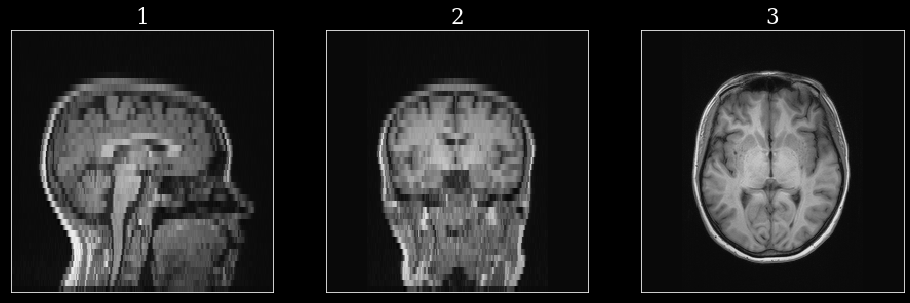

In [6]:
center_vol_plot(lr_vol, target_shape=(256, 256, 256))

## For now, we're using the MLT-generated filters. In the future we will replace these with the ideal PRFB using our best estimate of the LPF.

In [7]:
hs_fpath = Path("./weights/6-channel-PR-filter-bank_20220329_154258/hs.pt")
fs_fpath = Path("./weights/6-channel-PR-filter-bank_20220329_154258/fs.pt")

hs = torch.load(hs_fpath)
fs = torch.load(fs_fpath)

hs = [h.to(device) for h in hs]
fs = [f.to(device) for f in fs]

# Check the quality of these PR filters

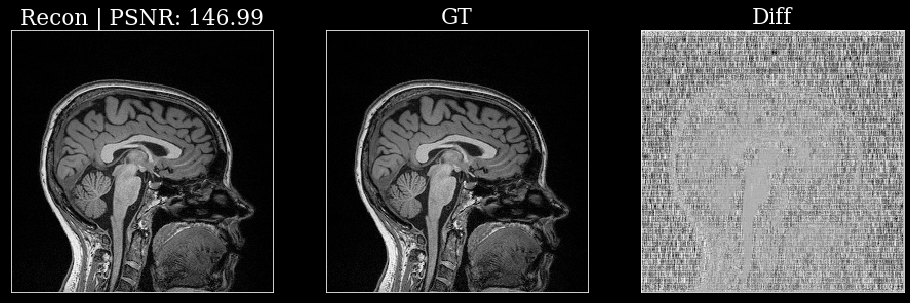

In [8]:
gt_slice = gt_vol[128, :, :]
gt_slice, *_ = normalize(gt_slice)
data_range = gt_slice.max() - gt_slice.min()

# send through analysis bank
gt_coefs = analyze(torch.from_numpy(gt_slice).to(device), hs)

# rearrange as 2D
gt_coefs_2d = torch.stack([batch_1d_to_2d(d, 256) for d in gt_coefs], dim=1)

# rearrange as 1D by putting channels first
gt_coefs_1d = torch.stack([batch_2d_to_1d(d_hat) 
                         for d_hat in gt_coefs_2d.permute(1, 0, 2, 3)], dim=0)

# TODO: This end-cropping is a magic number. Why is it -2 or -4???
gt_recon = synthesize(gt_coefs_1d, fs, apply_crop=True).detach().cpu().numpy()[:, :-2]

# gt_coefs = analyze(torch.from_numpy(gt_slice).to(device), hs)
# gt_recon = synthesize(gt_coefs, fs).detach().cpu().numpy()
gt_recon[gt_recon < gt_slice.min()] = gt_slice.min()
gt_recon[gt_recon > gt_slice.max()] = gt_slice.max()

psnr = peak_signal_noise_ratio(gt_recon, gt_slice, data_range=data_range)
multiplot([gt_recon, gt_slice, (gt_recon-gt_slice)], titles=[f'Recon | PSNR: {psnr:.2f}', 'GT', 'Diff'])

# Stage 2: Learn a generative model $f_\theta: \mathbb{R}^k \rightarrow \mathbb{R}^{M \times \frac{N}{M}}$
With $M$ as the number of channels and $N$ is the original signal length. So in this case, we set $M=6$ and $N=256$ and $f_\theta$ will learn the distribution of $256-$length signals from the in-plane. This may pose a problem, since the in-plane signals are surrounded by air on all sides, but the through-plane signal is not; the neck runs to the edge of the signal.

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch

def pixel_shuffle(x, target_shape):
    """Modified from https://gist.github.com/davidaknowles/6e95a643adaf3960d1648a6b369e9d0b"""
    num_batches, num_channels, nx = x.shape
    num_channels = num_channels // scale
    out = x.contiguous().view(num_batches, num_channels, scale, nx)
    out = out.permute(0, 1, 3, 2).contiguous()
    out = out.view(num_batches, num_channels, nx * scale)
    return out

class Downsample(nn.Module):
    def __init__(self, scale_factor, mode, recompute_scale_factor, align_corners):
        super().__init__()
        
        self.scale_factor = scale_factor
        self.mode = mode
        self.recompute_scale_factor = recompute_scale_factor
        self.align_corners = align_corners
        
    def forward(self, x):
        return F.interpolate(
            x, 
            scale_factor=self.scale_factor, 
            mode=self.mode, 
            recompute_scale_factor=self.recompute_scale_factor,
            align_corners=self.align_corners
        )

class Generator(nn.Module):
    def __init__(self, img_size, latent_dim, channels, filters):
        super().__init__()
        
        self.channels = channels
        self.img_size = img_size
        self.filters = filters
        self.init_size = img_size // 16
        
        self.net = nn.Sequential(
            nn.Linear(latent_dim, filters * self.init_size),
            nn.LeakyReLU(inplace=False),
            nn.Linear(filters * self.init_size, filters * 2),
            nn.LeakyReLU(inplace=False),
            nn.Linear(filters * 2, filters * 4),
            nn.LeakyReLU(inplace=False),
            nn.Linear(filters * 4, filters * 8),
            nn.LeakyReLU(inplace=False),
            nn.Linear(filters * 8, filters * 16),
            nn.LeakyReLU(inplace=False),
            nn.Linear(filters * 16, channels * img_size),
            nn.Tanh(),
        )

    def forward(self, z):
        B = z.shape[0]
        return self.net(z).view(B, self.channels, self.img_size)

class Discriminator(nn.Module):
    def __init__(self, img_size, channels, filters):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(img_size, img_size // 2 * filters),
            nn.LeakyReLU(inplace=False),
            nn.Dropout(0.25),
            nn.Linear(img_size // 2 * filters, img_size // 4 * filters),
            nn.LeakyReLU(inplace=False),
            nn.Dropout(0.25),
            nn.Linear(img_size // 4 * filters, img_size // 8 * filters),
            nn.LeakyReLU(inplace=False),
            nn.Dropout(0.25),
            nn.Linear(img_size // 8 * filters, 1),
        )

    def forward(self, img):
        B, N, M = img.shape
        return self.net(img.view(B, N*M))

In [10]:
k = 512
# TODO: figure out how to calculate this. This is in my notes somewhere
N = 45

G = Generator(
    img_size=N, 
    latent_dim=k, 
    channels=M, 
    filters=256,
).to(device)

D = Discriminator(
    filters=32,
    img_size=N*M,
    channels=M,
).to(device)

In [11]:
lr = 1e-4
opt_G = torch.optim.AdamW(G.parameters(), lr=lr)
opt_D = torch.optim.AdamW(D.parameters(), lr=lr)

opt_G.zero_grad()
opt_G.step()

opt_D.zero_grad()
opt_D.step()

# Loss function
adversarial_loss = torch.nn.BCEWithLogitsLoss().to(device)

In [12]:
from utils.train_loader_1D_apply_FB import TrainSet
from torch.utils.data import DataLoader

In [13]:
batch_size = 64
n_iters = 100000 * batch_size

In [14]:
ds = TrainSet(
    vol_fpath=lr_fpath,
    n_iters=n_iters,
    lr_dim=2,
)

In [15]:
data_loader = DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=8,
)

In [16]:
discrim_freq = 4

In [17]:
with tqdm(total=n_iters) as pbar:    
    pbar_dict = {
        'G_disrcrim_loss': np.finfo(np.float32).max,
        'D_disrcrim_loss': np.finfo(np.float32).max,
    }
    # Adversarial ground truths
    valid = torch.ones((batch_size, 1), requires_grad=False).to(device)
    fake = torch.zeros((batch_size, 1), requires_grad=False).to(device)

    for cur_step, real_imgs_cpu in enumerate(data_loader):
        real_imgs = torch.stack(analyze(real_imgs_cpu.to(device), hs), axis=1)
        n_batch = real_imgs.shape[0]
        
        # -----------------
        #  Train Generator
        # -----------------
        # freeze the discriminator
        for p in D.parameters():
            p.requires_grad = False
        opt_G.zero_grad()

        # Sample noise as generator input
        z = torch.randn(n_batch, 1, k, device=device)

        # Generate a batch of images
        gen_imgs = G(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(D(gen_imgs), valid[:n_batch])
        g_loss.backward()
        opt_G.step()
#         scheduler_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        if cur_step % discrim_freq == 0:
            # unfreeze the discriminator
            for p in D.parameters():
                p.requires_grad = True

            opt_D.zero_grad()

            # Measure discriminator's ability to classify real from generated samples
            if np.random.rand() < 0.5:
                d_loss = adversarial_loss(D(real_imgs), valid[:n_batch])
            else:
                d_loss = adversarial_loss(D(gen_imgs.detach()), fake[:n_batch])

            d_loss.backward()
            opt_D.step()
#             scheduler_D.step()

        pbar_dict['G_disrcrim_loss'] = g_loss.item()
        pbar_dict['D_disrcrim_loss'] = d_loss.item()

        pbar.set_postfix({k: f'{v:.4f}' for k, v in pbar_dict.items()})
        pbar.update(batch_size)

6845312it [19:18, 5911.14it/s, G_disrcrim_loss=1.2424, D_disrcrim_loss=0.5051]                                                                              


KeyboardInterrupt: 

In [18]:
# generate some samples
out = []
z = torch.randn(n_batch, 1, k, device=device)

# Generate a batch of images
gen_imgs = G(z)
out.append(gen_imgs)

In [19]:
gen_imgs.shape

torch.Size([32, 6, 45])

In [20]:
out = torch.cat(out)

In [21]:
out.shape

torch.Size([32, 6, 45])

In [22]:
# TODO: This end-cropping is a magic number. Why is it -2 or -4???
x_hat = synthesize(out.permute(1, 0, 2), fs, apply_crop=True).detach().cpu().numpy()[:, :-2]

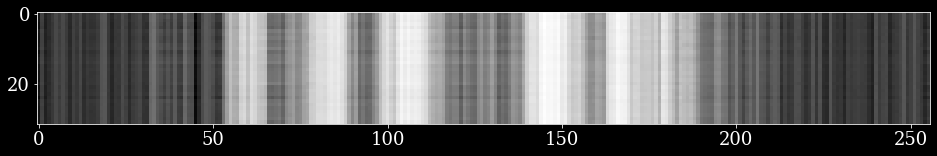

In [23]:
plt.imshow(x_hat)

# Stage 3: CSGM w/ILO

In [251]:
def mse(a, b):
    return ((a - b) ** 2).sum()

def pred_to_img(G, z, fs):
    with torch.no_grad():
        # Generate a batch of images
        M = len(fs)
        out = G(z)
        out = out.view(z.shape[0], M, out.shape[-1]//M)
        
        ret = synthesize(out.permute(1, 0, 2), fs, apply_crop=True).detach().cpu().numpy()[:, :-2]
    return ret

def project_onto_l1_ball(x, eps):
    """
    From ILO code
    
    See: https://gist.github.com/tonyduan/1329998205d88c566588e57e3e2c0c55
    """
    original_shape = x.shape
    x = x.view(x.shape[0], -1)
    mask = (torch.norm(x, p=1, dim=1) < eps).float().unsqueeze(1)
    mu, _ = torch.sort(torch.abs(x), dim=1, descending=True)
    cumsum = torch.cumsum(mu, dim=1)
    arange = torch.arange(1, x.shape[1] + 1, device=x.device)
    rho, _ = torch.max((mu * arange > (cumsum - eps)) * arange, dim=1)
    theta = (cumsum[torch.arange(x.shape[0]), rho.cpu() - 1] - eps) / rho
    proj = (torch.abs(x) - theta.unsqueeze(1)).clamp(min=0)
    x = mask * x + (1 - mask) * proj * torch.sign(x)
    return x.view(original_shape)

def ilo(G, z_init, y, lrs, n_iters, N_ILO_LAYERS, R, l1_epsilons, fs, device):
    # track latent vectors in a list
    zs = [z_init.detach()]
    # predict as we go for debugging
    preds = [pred_to_img(G, z_init, fs)]
    
    coefs = [G(z_init).view(z_init.shape[0], M, 45)]
        
    # set up loss functions
    losses = {
        'mse': torch.nn.MSELoss().to(device),
#         'lpips': lpips.LPIPS(net='vgg').to(device),
#         'tv': TotalVariation().to(device),
    }

    # Decompose generator
    Gs = list(G.children())

    for i in range(1, N_ILO_LAYERS + 1):
        # decompose generator by one layer and one activation
        j = i * 2
        G_curr = torch.nn.Sequential(*Gs[j:j+2])
        G_curr_to_img = torch.nn.Sequential(*Gs[j:])
        G_prev = torch.nn.Sequential(*Gs[j-2:j])
        G_prev_to_img = torch.nn.Sequential(*Gs[j-2:])
        
        ##### CSGM previous layer #####
        print("#"*10, f"CSGM Layer {i-1}", "#"*10)
        z = torch.zeros_like(zs[i-1], requires_grad=True, device=device)
        z.data = zs[i-1].data
        opt = torch.optim.Adam([z], lr=lrs[i-1])
        
        with tqdm(total=n_iters[i-1]) as pbar:    
            pbar_dict = {
                'loss': np.finfo(np.float32).max,
#                 'mse': np.finfo(np.float32).max,
#                 'lpips': np.finfo(np.float32).max,
#                 'tv': np.finfo(np.float32).max,
            }
            for _ in range(n_iters[i-1]):
                opt.zero_grad()
                
                x_hat = G_prev_to_img(z)
                x_hat = x_hat.view(z.shape[0], M, x_hat.shape[-1]//M)
                
                # take only the LR for estimation
                mse_loss = losses['mse'](x_hat[:, 0, :], y)
#                 lpips_loss = losses['lpips'](y_hat, y)
#                 tv_loss = losses['tv'](x_hat) # smoothness in HR estimate
#                 loss = mse_loss + lpips_loss + tv_loss
                loss = mse_loss

                loss.backward()
                opt.step()

                pbar_dict['loss'] = loss.detach().cpu().numpy().item()
#                 pbar_dict['mse'] = mse_loss.detach().cpu().numpy().item()
#                 pbar_dict['lpips'] = lpips_loss.detach().cpu().numpy().item()
#                 pbar_dict['tv'] = tv_loss.detach().cpu().numpy().item()
                pbar.set_postfix({k: f'{v:.4f}' for k, v in pbar_dict.items()})
                pbar.update(1)

        # get current intermediate representation
        zs.append(G_prev(z).detach())
        
#         ##### L1 ball current layer #####
#         print("#"*10, f"L1 Ball Layer {i}", "#"*10)

#         for r in range(R):
#             # set up optimization for z_i
#             z = torch.zeros_like(zs[i], requires_grad=True, device=device)
#             z.data = zs[i].data
#             opt = torch.optim.Adam([z], lr=lrs[i-1])

#             if r > 0:
#                 # set up previous z_i
#                 z_i_prev_round = z.clone().detach()

#             # optimize as normal, constraint enforced within loop
#             with tqdm(total=n_iters[i-1]) as pbar:    
#                 pbar_dict = {
#                     'loss': np.finfo(np.float32).max,
# #                     'mse': np.finfo(np.float32).max,
# #                     'lpips': np.finfo(np.float32).max,
# #                     'tv': np.finfo(np.float32).max,
#                 }
#                 for _ in range(n_iters[i-1]):
#                     opt.zero_grad()

#                     x_hat = G_curr_to_img(z)
#                     x_hat = x_hat.view(z.shape[0], M, x_hat.shape[-1]//M)

#                     mse_loss = losses['mse'](x_hat[:, 0, :], y)
# #                     lpips_loss = losses['lpips'](y_hat, y)
# #                     tv_loss = losses['tv'](x_hat) # smoothness in HR estimate
# #                     loss = mse_loss + lpips_loss# + tv_loss
#                     loss = mse_loss

#                     loss.backward()
#                     opt.step()

#                     pbar_dict['loss'] = loss.detach().cpu().numpy().item()
# #                     pbar_dict['mse'] = mse_loss.detach().cpu().numpy().item()
# #                     pbar_dict['lpips'] = lpips_loss.detach().cpu().numpy().item()
# #                     pbar_dict['tv'] = tv_loss.detach().cpu().numpy().item()
#                     pbar.set_postfix({k: f'{v:.4f}' for k, v in pbar_dict.items()})

#                     # to do Projected Gradient Descent, we enforce our constraint
#                     # after each optimizer step but within the loop
#                     # So here we project our solution within the L1 ball centered
#                     # on the previous solution
#                     if r == 0:
#                         # first round, just look around the current solution
#                         project_onto_l1_ball(zs[i], l1_epsilons[r])
#                     else:
#                         project_onto_l1_ball(zs[i] - z_i_prev_round, l1_epsilons[r])

#                     pbar.update(1)

#             # Project back into generator's range by optimizing z_{i-1}
#             # to be close to z_i
#             z = torch.zeros_like(zs[i-1], requires_grad=True, device=device)
#             z.data = zs[i-1].data
#             opt = torch.optim.Adam([z], lr=lrs[i-1])

#             with tqdm(total=n_iters[i-1]) as pbar:    
#                 pbar_dict = {'mse': np.finfo(np.float32).max}
#                 for _ in range(n_iters[i-1]):
#                     opt.zero_grad()
#                     mse_loss = losses['mse'](G_prev(z), zs[i])
#                     mse_loss.backward()
#                     opt.step()

#                     pbar_dict['mse'] = mse_loss.detach().cpu().numpy().item()
#                     pbar.set_postfix({k: f'{v:.4f}' for k, v in pbar_dict.items()})
#                     pbar.update(1)

#             # update z_i
#             zs[i] = G_prev(z).detach()

        
        preds.append(pred_to_img(G_curr_to_img, zs[i], fs))
        coefs.append(G_curr_to_img(zs[i]).view(z.shape[0], M, 45))
    return preds, coefs

In [252]:
obs = lr_vol[128]

pad = 0
obs = np.pad(obs, ((0, 0), (pad, 0)))
obs, orig_min, orig_max = normalize(obs, a=-1, b=1)

obs_interp = resize(obs, (1, 1/M), order=5)
obs_interp = torch.from_numpy(obs_interp).unsqueeze(0).unsqueeze(1).to(device)

# this padding is added temporarily because our downsampling is not quite integer,
# or because we have some other incorrect assumption in the PRFB latent space...
obs = F.pad(torch.from_numpy(obs), (0, 2)).to(device)

In [253]:
# ensure G is frozen
for p in G.parameters():
    p.requires_grad=False

In [254]:
N_ILO_LAYERS = 5
lrs = [1e-1, 1e-2, 1e-2, 1e-2, 1e-2]
n_iters = [10000, 5000, 5000, 5000, 5000]
R = 3
l1_epsilons = [100, 200, 400]

In [255]:
z_init = torch.randn(256, k).to(device)

In [256]:
preds, coefs = ilo(G.net, z_init, obs, lrs, n_iters, N_ILO_LAYERS, R, l1_epsilons, fs, device)

########## CSGM Layer 0 ##########


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 411.88it/s, loss=0.0729]


########## CSGM Layer 1 ##########


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:11<00:00, 424.99it/s, loss=0.0661]


########## CSGM Layer 2 ##########


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:11<00:00, 436.36it/s, loss=0.0198]


########## CSGM Layer 3 ##########


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:10<00:00, 457.43it/s, loss=0.0094]


########## CSGM Layer 4 ##########


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:10<00:00, 492.45it/s, loss=0.0117]


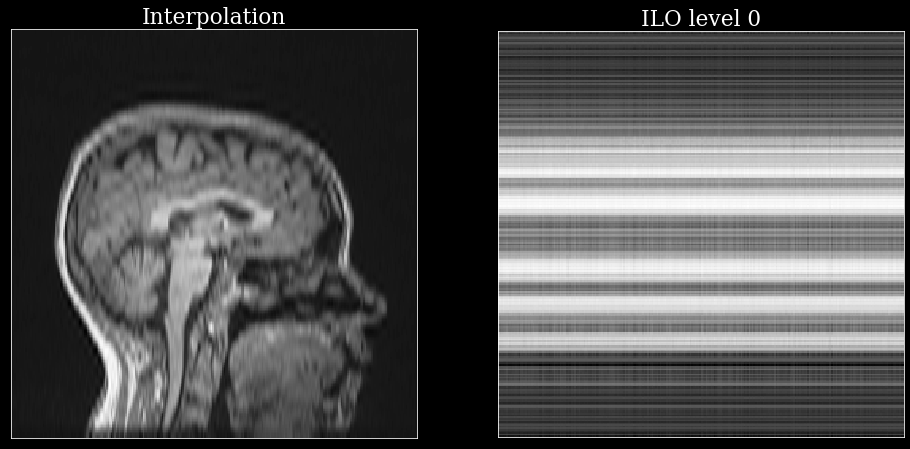

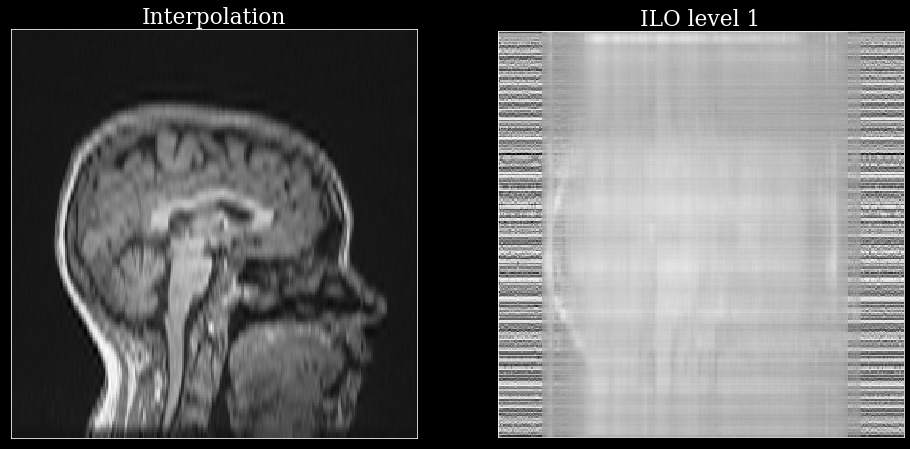

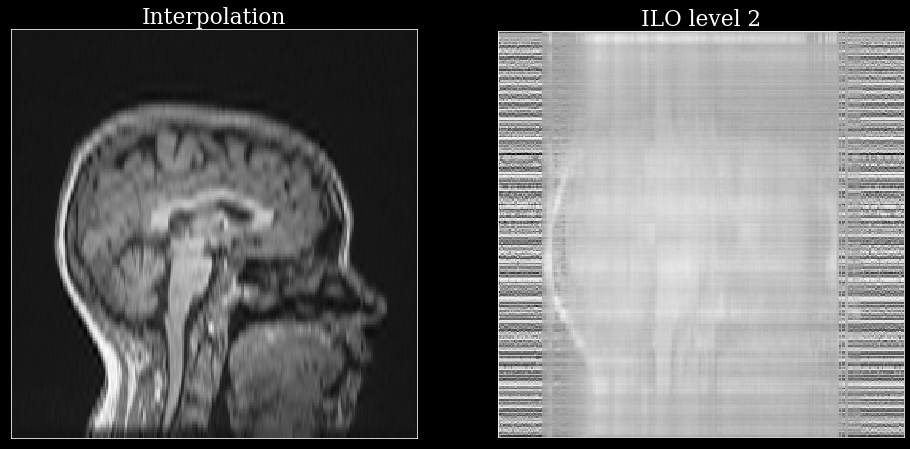

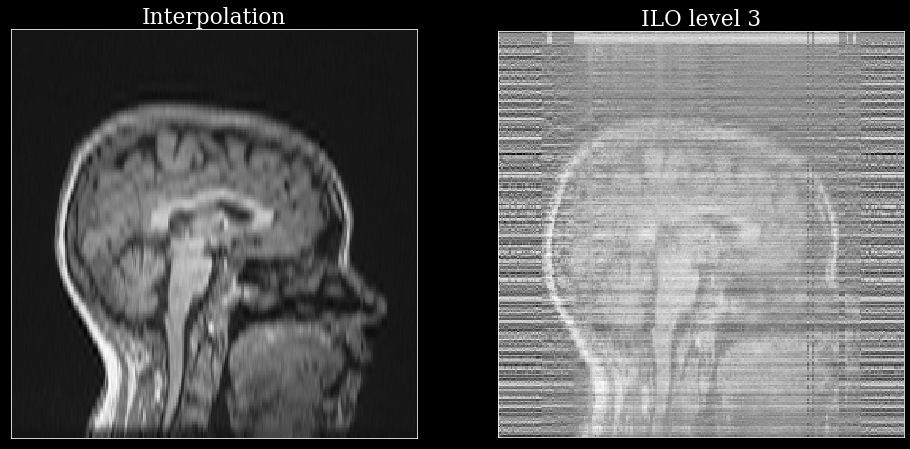

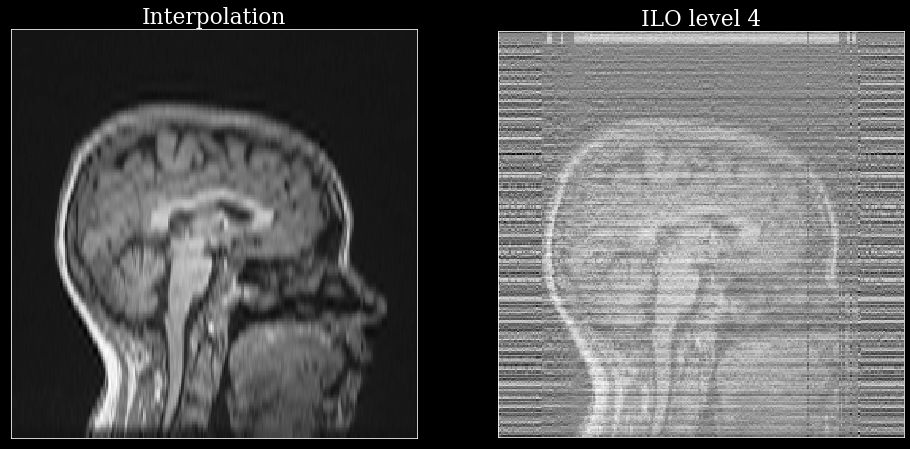

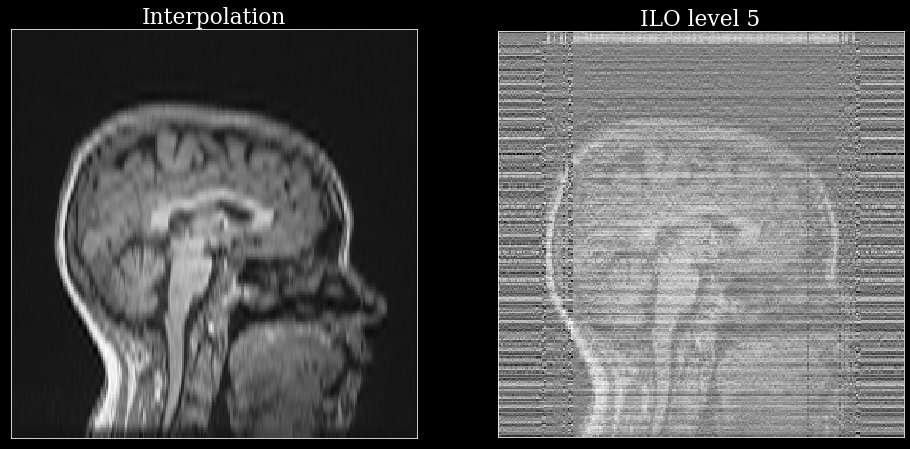

In [257]:
for i, pred in enumerate(preds):
    multiplot([obs_interp.detach().cpu().numpy().squeeze(), pred], 
              titles=['Interpolation', f'ILO level {i}'])

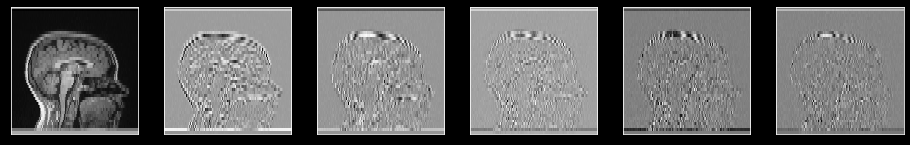

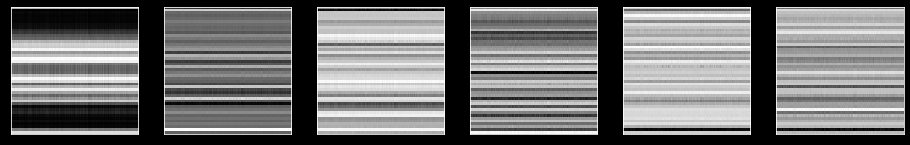

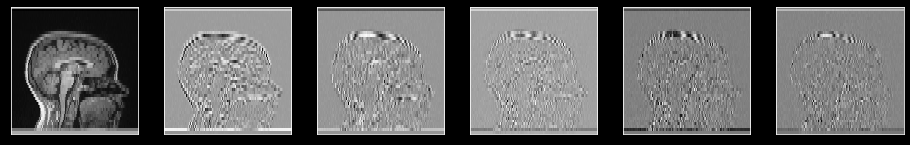

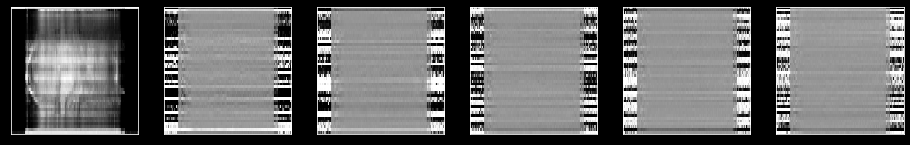

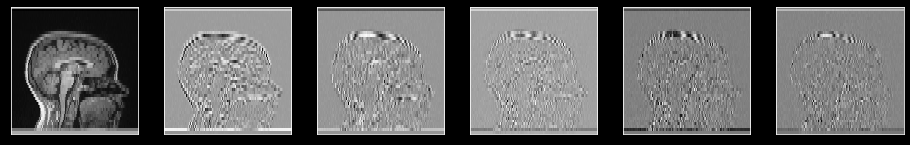

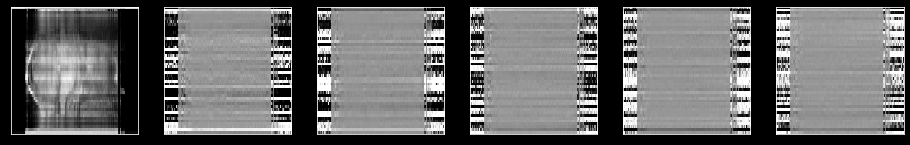

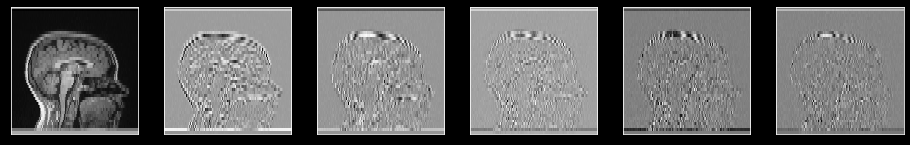

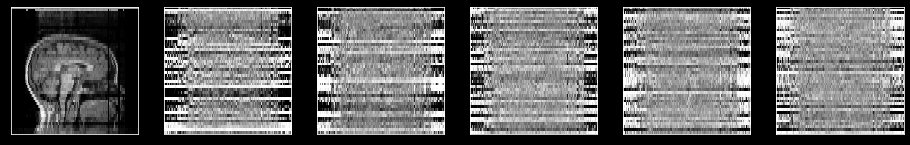

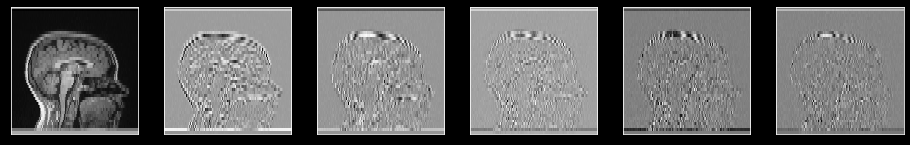

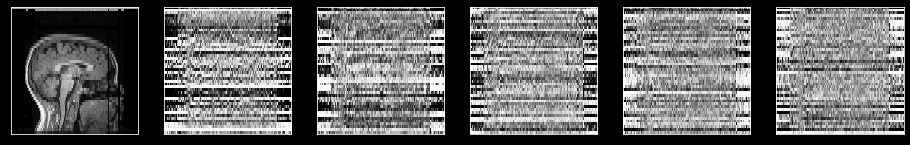

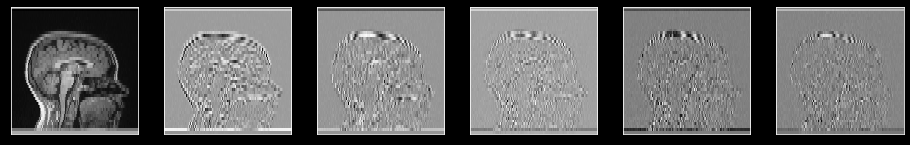

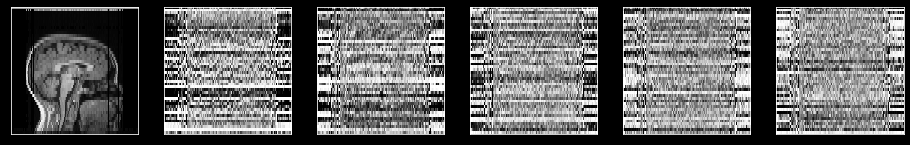

In [269]:
gt_coefs = analyze(torch.from_numpy(gt_slice).to(device), hs)

for i in range(len(coefs)):
            
    a = [x.detach().cpu().numpy() for x in gt_coefs]
    b = coefs[i].permute(1, 0, 2).detach().cpu().numpy()
    multiplot(a, titles=['']*6, target_shape=(256, 256),)
    multiplot(b, titles=['']*6, target_shape=(256, 256),)
        
        
#             titles=['LR', f'ILO level {i}, Subband {j}'],
#             target_shape=(256, 256),
#           )